## Gaussian Mixture Model
#### James Saslow 5/10/2020
Models $\textbf{K}$ gaussians to a data set $\textbf{X}$, where X $\epsilon$ $\mathbb{R}^{N}$ for $N>1$.

In the "GMM 1D" script, the Gaussian Mixture Model (GMM) is implimented for $K$ gaussians with X $\epsilon$ $\mathbb{R}^{1}$

$\textbf{Primary functions in the script}$:

> GMM(X, K, eps) 

- X is the data set, K is the number of gaussians you desire to model, and eps is a small number that breaks the GMM at convergence.

- GMM(X,K,eps) returns an array containing the $\hat{\phi}$, $\hat{\mu}$, $\hat{\Sigma}$ for each modeled gaussian.

- In particular, if we set mix = GMM(X,K,eps), then $mix[0] = \hat{\phi}$, $mix[1] = \hat{\mu}$, and $mix[2] = \hat{\Sigma}$ for each gaussian.

> GMM_plotphi(mix)

- Can be used for X in any dimensional space. i.e. X $\epsilon$ $\mathbb{R}^{N}$ for any positive integer $N$

- Uses the result of the GMM to visually plot the $\hat{\phi}$ component of each gaussian in a bar chart.

- mix = GMM(X,K,eps)

> GMM_plot2D(mix,X)

- Can only be used for X $\epsilon$ $\mathbb{R}^{2}$

- Plots the data set X as well as level curves (or rings as seen on the graph) for the bivariate normal distribution for each gaussian. 

- 68% of the data falls within 1 ring.

- 95% of the data falls within 2 rings.

- 99.7% of the data falls within 3 rings.

- Each gaussian is color coded to represent its associated $\hat{\phi}$ to give the 3D 'feel' of each gaussian

$\textbf{Useful References}$

- Understanding the GMM in 1D https://brilliant.org/wiki/gaussian-mixture-model/
- GMM in higher dimensions https://en.wikipedia.org/wiki/Mixture_model#Multivariate_Gaussian_mixture_model
- An introduction for k means clustering Youtube video https://www.youtube.com/watch?v=4b5d3muPQmA
- Another article regarding kmeans https://brilliant.org/wiki/k-means-clustering/


In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import matplotlib.cm as pcm
import matplotlib as mpl

np.random.seed(2)

In [2]:
# Functions

# This function multiplies column vector * horizontal vector -> matrix
# For some reason np.matmul does not do this properly so this is a work around
def sqr(array):
    sqr = np.zeros((len(array), len(array)))
    for j in range(len(array)):
        for i in range(len(array)):
            sqr[i,j] = array[i] * array[j]
    return sqr

#Returns the magnitude of a numpy array
def mag(array):
    return np.sqrt(sum(array**2))

# Calculates the distance between 2 points in euclidean space
def dist(mu,x):
    array = mu - x
    return mag(array)

# Multivariate Normal 
def mvn(x, mu, cov):
    return multivariate_normal.pdf(x, mu, cov)

In [3]:
#K Means

# Chooses a "random" initial mean for each cluster
def init_means(X,K):
    means = []
    for i in range(K):
        means.append(X[i])
    return means

# #Gives the distance between mean values and each point in the data set X
def dist_matrix(X,K, means):
    distance = np.zeros((K,len(X)))
    for i in range(K):
        for j in range(len(X)):
            distance[i,j] = dist(means[i], X[j])
    return np.transpose(distance)

# Assigns each point in the data set X to a class
def classify(X, distance):
    classes = []
    for i in range(len(X)):
        point_distance = distance[i]
        Min = min(point_distance)
        for j in range(len(point_distance)):
            if Min == point_distance[j]:
                classes.append(j)
    return classes

# Compute the means of the X's that belong to each class
def new_means(X,K,classes):
    new_means = []
    for i in range(K):
        List = []
        for j in range(len(X)):
            if classes[j] == i:
                List.append(X[j])
        new_means.append(sum(List)/len(List))
    return new_means

#----------------------------------------------------------------

# K means will be our mu_hat initialization step in the GMM

# Set kmeans = mu_hat
def kmeans(X,K, kmeans_eps):
    
    means = init_means(X,K)
    
    # Keeping a record of the means for every iteration
    mean_list = [means]
    
    itn = 100
    for i in range(itn):
        #K means algorithm
        distance = dist_matrix(X,K, means)
        classes = classify(X,distance)
        means = new_means(X,K,classes)
        mean_list.append(means)
    
        # Cutoff condition
        diff = np.array(mean_list[len(mean_list)-1]) - np.array(mean_list[len(mean_list)-2])
        magnitude_change = []
        for t in range(len(diff)):
            magnitude_change.append(mag(diff[t]))
        avg_mag_change = np.mean(magnitude_change)
        if avg_mag_change < kmeans_eps:
            break
    return means

In [4]:
#GMM

#Initialization step
def init_phi_hat(X,K):
        phi_hat = []
        for i in range(K):
            phi_hat.append(1/K)
        return phi_hat

#Replacing init_mu_hat function with kmeans

def init_cov_hat(X,K):
    cov_hat = []
    cov = np.cov(np.transpose(X))
    for i in range(K):
        cov_hat.append(cov)
    return cov_hat

#E-step
def gamma(i,k,X,K,phi_hat, mu_hat, cov_hat):
    num = (phi_hat[k])*(mvn(X[i], mu_hat[k], cov_hat[k]))
    array = []
    for j in range(K):
        array.append(phi_hat[j]*mvn(X[i],mu_hat[j], cov_hat[j]))
    den = sum(array)
    return num/den


def make_matrix(K,X,phi_hat, mu_hat, cov_hat):
    gamma_matrix = np.zeros([K, len(X)-1])
    for i in range(K):
        for j in range(len(X)-1):
            gamma_matrix[i,j] = gamma(j,i,X,K,phi_hat, mu_hat, cov_hat)
    return np.transpose(gamma_matrix)


# M-step
def phi_func(X,k, gamma_matrix):
    array = []
    for i in range(len(X)-1):
        array.append(gamma_matrix[i,k])
    return (1/len(X))*sum(array)

def mu_func(X,k, gamma_matrix):
    array1 = []
    array2 = []
    for i in range(len(X)-1):
        array1.append(X[i] * gamma_matrix[i,k])
        array2.append(gamma_matrix[i,k])
    return sum(array1)/sum(array2)

def cov_func(X,k, gamma_matrix, mu_hat):
    array1 = []
    array2 = []
    for i in range(len(X)-1):
        array1.append(gamma_matrix[i,k]* sqr(X[i] - mu_hat[k]))
        array2.append(gamma_matrix[i,k])
    return sum(array1)/sum(array2)


# New 'updated' hat vectors
def new_phi(X,K, gamma_matrix):
    phi_hat = []
    for i in range(K):
        phi_hat.append(phi_func(X,i, gamma_matrix))
    return phi_hat


def new_mu(X,K, gamma_matrix):
    mu_hat = []
    for i in range(K):
        mu_hat.append(mu_func(X,i, gamma_matrix))
    return mu_hat


def new_cov(X,K, gamma_matrix, mu_hat):
    cov_hat = []
    for i in range(K):
        cov_hat.append(cov_func(X,i, gamma_matrix,mu_hat))
    return cov_hat

In [5]:
# Gaussian Mixture Model Function

def GMM(X, K , eps):
    # Initialization Step
    phi_hat = init_phi_hat(X,K)
    mu_hat = kmeans(X,K,0.005)
    
    cov_hat = init_cov_hat(X,K)
    
    #Keeping a record of EM algorithm
    phi_list = [phi_hat]
    mu_list  = [mu_hat]
    cov_list = [cov_hat]
    
    itn = 100
    for t in range(itn):
        # E-step
        gamma_matrix = make_matrix(K,X,phi_hat, mu_hat, cov_hat)
        
        # M-step
        phi_hat = new_phi(X,K, gamma_matrix)
        mu_hat = new_mu(X,K, gamma_matrix)
        cov_hat = new_cov(X,K, gamma_matrix, mu_hat)
        
        phi_list.append(phi_hat)
        mu_list.append(mu_hat)
        cov_list.append(cov_hat)
        
        #Cutoff condition
        diff = np.array(mu_list[len(mu_list)-1]) - np.array(mu_list[len(mu_list)-2])
        magnitude_change = []
        for t in range(len(diff)):
            magnitude_change.append(mag(diff[t]))
        avg_mag_change = np.mean(magnitude_change)
        if avg_mag_change < eps:
            break
    
    return phi_hat, mu_hat, cov_hat

In [16]:
# Making Arbitrary Data

# This can only handle data with dim > 1


mean_1      = np.array([0.5,0.5])
cov_1       = 0.02*np.array([[2,1],[1,2]])
data1       = np.random.multivariate_normal(mean_1,cov_1,150)

mean_2      = np.array([-0.5,-0.5])
cov_2       = 0.02*np.array([[3,-1],[-1,2]])
data2       = np.random.multivariate_normal(mean_2,cov_2,350)

mean_3      = np.array([1,1.5])
cov_3       = 0.02*np.array([[5,2],[2,1]])
data3       = np.random.multivariate_normal(mean_3,cov_3,250)


X = np.vstack((data1, data2, data3))
np.random.shuffle(X)

# plt.scatter(np.transpose(X)[0], np.transpose(X)[1], s = 0.1)
# plt.show()

#-------------------------------------------------------------------------------------------------------

T = time.process_time()

mix = GMM(X,3,0.005)

elapsed_time = time.process_time() - T
print('Computation Time = ',elapsed_time,' seconds')

print(' ')
print('phi_hat = ',mix[0])
print(' ')
print('mu_hat = ',mix[1])
print(' ')
print('cov_hat = ')
for i in range(len(mix[2])):
    print((mix[2])[i])
    print(' ')

Computation Time =  17.75  seconds
 
phi_hat =  [0.20062495025884827, 0.46665371042267256, 0.3313880059851455]
 
mu_hat =  [array([0.48851371, 0.50553628]), array([-0.52129041, -0.4717238 ]), array([1.00747037, 1.50262327])]
 
cov_hat = 
[[0.03457364 0.01769105]
 [0.01769105 0.0404515 ]]
 
[[ 0.058419   -0.01907835]
 [-0.01907835  0.04099237]]
 
[[0.08750576 0.03467338]
 [0.03467338 0.01769316]]
 


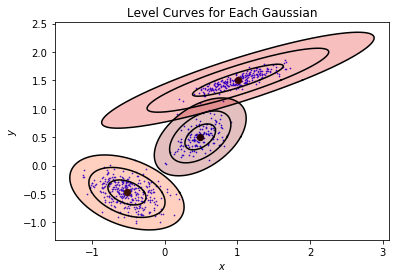

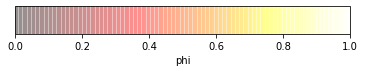

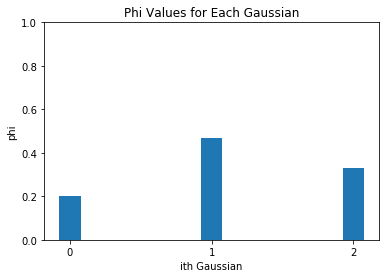

In [17]:
#Plotting Options


#Can use this plotting function for any dimensional space
def GMM_plotphi(mix):
    fig, ax = plt.subplots()
    phi_hat = mix[0]
    cov_hat = mix[2]
    index = []
    for i in range(len(phi_hat)):
        index.append(str(i))
    
    plt.title('Phi Values for Each Gaussian')
    plt.xlabel('ith Gaussian')
    plt.ylabel('phi')
    plt.ylim(0,1)
    barlist = plt.bar(index, phi_hat, width=0.15, align = 'center')

    
    # Gives the differential entropy for a multivariate Gaussian
    def diff_entropy(mix):
        cov_hat = mix[2]
        dim = len(cov_hat[0])
        return ((0.5 * dim) * (1 + np.log(2 * np.pi))) + 0.5 * np.log(np.linalg.det(cov_hat))
    
    entropy = diff_entropy(mix)
    
    # This prints differential entropies associated with each gaussian
#     for i in range(len(phi_hat)):
#         plt.text(int(index[i])-0.09, phi_hat[i] + 0.02, str(round(entropy[i],2)), color = 'red')
    plt.show()


    
#Only works for 2D space
def GMM_plot2D(mix,X):
    # 68% of the data falls within 1 ring
    # 95% of the data falls within 2 rings
    # 99.7% of the data falls within 3 rings
    fig2 = plt.figure()
    ax2  = fig2.add_subplot(111)
    plt.scatter(np.transpose(X)[0], np.transpose(X)[1], c = 'blue', s = 0.4, marker = 'o')
    
    phi_hat = mix[0]
    mu_hat  = mix[1]
    cov_hat = mix[2]
    
    plt.scatter(np.transpose(mu_hat)[0], np.transpose(mu_hat)[1], s = 40, color = 'black')
    
    def contour(phi_hat, mu_hat, cov_hat):
        K = len(mu_hat)
        t = np.linspace(0,2*np.pi,1000)
        
        # x(t) and y(t) are level curves for a bivariate gaussian in parametric form
        def x(t,C):
            constant = Sxy/(Sx*Sy)
            return mu_x + (C*Sx*np.cos(t))/np.sqrt(1 - constant*np.sin(2*t))

        def y(t,C):
            constant = Sxy/(Sx*Sy)
            return mu_y + (C*Sy*np.sin(t))/np.sqrt(1 - constant*np.sin(2*t))
        
        #Plotting Level Curves for each different gaussian
        for i in range(K):
            mu = mu_hat[i]
            cov = cov_hat[i]
            mu_x = mu[0]
            mu_y = mu[1]
            Sx = np.sqrt(cov[0,0])
            Sy = np.sqrt(cov[1,1])
            Sxy = cov[0,1]
            
            for j in range(3):
                # C = number of standard deviations from the mean
                C = j+1
                plt.plot(x(t,C),y(t,C), color = 'black')
            
            #Filling in the color for phi for each gaussian.
            colormap = pcm.get_cmap('hot')
            rgba = colormap(phi_hat[i])
            plt.fill_between(x(t,3), y(t,0), y(t,3), alpha = 0.25,facecolor = rgba)
            plt.title('Level Curves for Each Gaussian')
            plt.xlabel('$x$')
            plt.ylabel('$y$')
            
        # Making a 'heat' scale for phi
        fig, ax = plt.subplots(figsize=(6, 1))
        fig.subplots_adjust(bottom=0.5)
        cmap = mpl.cm.hot
        norm = mpl.colors.Normalize(vmin=0, vmax=1)
        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=ax, orientation='horizontal', label='phi', alpha = 0.25)
    
    #Plots level curves of each gaussian 1 standard deviation away from each other 
    contour(phi_hat,mu_hat,cov_hat)
    
    

if len((mix[1])[0]) == 2:
    GMM_plot2D(mix,X)

GMM_plotphi(mix)